In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch

torch.set_printoptions(edgeitems=2)
# Sets the seed for generating random numbers. Returns a torch.Generator object.
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ])
)

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4915, 0.4823, 0.4468),
            (0.2470, 0.2435, 0.2616)
        )
    ])
)

In [5]:
# 从cifar10里拿出飞机和鸟组成新的数据集，这个是datasets的子类
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
            for img, label in cifar10
            if label in [0, 2]]
cifar2_val = [(img, label_map[label])
                for img, label in cifar10_val
                if label in [0, 2]]

len(cifar2)

10000

In [6]:
import torch.nn as nn 

n_out = 2 

model = nn.Sequential(
    nn.Linear(
        3072, # input features
        512, # hidden layer size
    ),
    nn.Tanh(),
    nn.Linear(
        512, # hidden layer size 
        n_out,
    )
)

In [7]:
def softmax(x):
    # Returns a new tensor with the exponential of the elements of the input tensor input.
    return torch.exp(x) / torch.exp(x).sum()

In [8]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [9]:
softmax(x).sum()

tensor(1.)

In [10]:
softmax = nn.Softmax(dim=1) # 指定计算列数

x = torch.tensor([[1.0, 2.0, 3.0],
                [1.0, 2.0, 3.0]])

softmax(x), x.shape

(tensor([[0.0900, 0.2447, 0.6652],
         [0.0900, 0.2447, 0.6652]]),
 torch.Size([2, 3]))

In [11]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


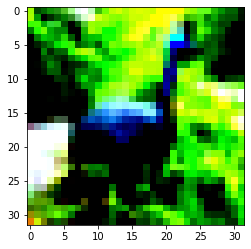

In [12]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [13]:
img_batch = img.view(-1).unsqueeze(0)


In [14]:
# 未训练模型
out = model(img_batch)
# [airplanes, bird]的概率
out

tensor([[0.4784, 0.5216]], grad_fn=<SoftmaxBackward>)

In [15]:
i, index = torch.max(out, dim=1)

index, i

(tensor([1]), tensor([0.5216], grad_fn=<MaxBackward0>))

In [16]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4,2))
# Writes all values from the tensor src into self at the indices specified in the index tensor. 
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [17]:
def mse(out):
    return ((out - truth) ** 2).sum(dim=1).mean()
mse(out)

tensor(0.1500)

In [18]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [19]:
0.6 * 0.7 * 0.9 * 0.8

0.3024

In [20]:
def likelihood(out):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod 

likelihood(out)

tensor([0.3024])

In [21]:
# nll
def neg_log_likelihood(out):
    return -likelihood(out).log()

neg_log_likelihood(out)

tensor([1.1960])

In [22]:
out0 = out.clone().detach() # Returns a new Tensor, detached from the current graph.
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

mse_comparison = torch.tensor([mse(o) for o in [out0, out, out2, out3]])
mse_comparison


tensor([0.0750, 0.1500, 0.2500, 0.4750])

In [23]:
((mse_comparison / mse_comparison[1]) - 1) * 100

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [24]:
nll_comparison = torch.tensor([neg_log_likelihood(o)
                                for o in [out0, out, out2, out3]])
nll_comparison

tensor([0.7905, 1.1960, 1.6015, 2.9878])

In [25]:
((nll_comparison / nll_comparison[1]) - 1) * 100

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

In [26]:
softmax = nn.Softmax(dim=1)

log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])

x, x.shape, softmax(x)

(tensor([[  0., 104.]]), torch.Size([1, 2]), tensor([[0., 1.]]))

In [27]:
torch.log(softmax(x))

tensor([[-inf, 0.]])

In [28]:
log_softmax(x)

tensor([[-104.,    0.]])

In [29]:
torch.exp(log_softmax(x))

tensor([[0., 1.]])

In [30]:
mode = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

In [31]:
loss = nn.NLLLoss()

In [32]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

# 预测out和label的相似程度
loss(out, torch.tensor([label]))

tensor(-0.5216, grad_fn=<NllLossBackward>)

# 在cpu上跑没有batch的数据太慢了，而且很蠢
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss %f" % (epoch, float(loss)))

In [33]:
# 划分训练集
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle=True)

In [34]:
import torch 
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr = learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))


Epoch: 0, Loss: 0.379931
Epoch: 1, Loss: 0.510971
Epoch: 2, Loss: 0.447792
Epoch: 3, Loss: 0.653534
Epoch: 4, Loss: 0.447541
Epoch: 5, Loss: 0.291345
Epoch: 6, Loss: 0.486947
Epoch: 7, Loss: 0.270207
Epoch: 8, Loss: 0.547912
Epoch: 9, Loss: 0.238432
Epoch: 10, Loss: 0.257918
Epoch: 11, Loss: 0.356446
Epoch: 12, Loss: 0.538808
Epoch: 13, Loss: 0.226758
Epoch: 14, Loss: 0.299214
Epoch: 15, Loss: 0.311655
Epoch: 16, Loss: 0.138688
Epoch: 17, Loss: 0.289396
Epoch: 18, Loss: 0.329703
Epoch: 19, Loss: 0.491818
Epoch: 20, Loss: 0.121620
Epoch: 21, Loss: 0.239407
Epoch: 22, Loss: 0.256800
Epoch: 23, Loss: 0.362643
Epoch: 24, Loss: 0.146391
Epoch: 25, Loss: 0.224057
Epoch: 26, Loss: 0.317490
Epoch: 27, Loss: 0.242224
Epoch: 28, Loss: 0.189765
Epoch: 29, Loss: 0.247376
Epoch: 30, Loss: 0.152678
Epoch: 31, Loss: 0.370835
Epoch: 32, Loss: 0.170147
Epoch: 33, Loss: 0.153687
Epoch: 34, Loss: 0.224271
Epoch: 35, Loss: 0.091529
Epoch: 36, Loss: 0.133091
Epoch: 37, Loss: 0.123274
Epoch: 38, Loss: 0.120

In [35]:
import torch 
import torch.nn as nn
import torch.optim as optim 

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 512), # 更改中间层特征数量
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss %f" % (epoch, float(loss)))

Epoch: 0, Loss 0.326693
Epoch: 1, Loss 0.394001
Epoch: 2, Loss 0.328502
Epoch: 3, Loss 0.178092
Epoch: 4, Loss 0.364719
Epoch: 5, Loss 0.454674
Epoch: 6, Loss 0.548658
Epoch: 7, Loss 0.352326
Epoch: 8, Loss 0.636690
Epoch: 9, Loss 0.390800
Epoch: 10, Loss 0.355435
Epoch: 11, Loss 0.222640
Epoch: 12, Loss 0.202111
Epoch: 13, Loss 0.172411
Epoch: 14, Loss 0.271181
Epoch: 15, Loss 0.219212
Epoch: 16, Loss 0.613340
Epoch: 17, Loss 0.204373
Epoch: 18, Loss 0.314177
Epoch: 19, Loss 0.236539
Epoch: 20, Loss 0.180212
Epoch: 21, Loss 0.297169
Epoch: 22, Loss 0.147050
Epoch: 23, Loss 0.395495
Epoch: 24, Loss 0.217830
Epoch: 25, Loss 0.346799
Epoch: 26, Loss 0.122175
Epoch: 27, Loss 0.310462
Epoch: 28, Loss 0.117975
Epoch: 29, Loss 0.108739
Epoch: 30, Loss 0.289741
Epoch: 31, Loss 0.162111
Epoch: 32, Loss 0.343498
Epoch: 33, Loss 0.067240
Epoch: 34, Loss 0.145010
Epoch: 35, Loss 0.326151
Epoch: 36, Loss 0.075940
Epoch: 37, Loss 0.142854
Epoch: 38, Loss 0.160553
Epoch: 39, Loss 0.324590
Epoch: 40,

In [36]:
# 验证训练集准确率 不洗牌
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        print(correct, total)

print("accuracy: %f" % (correct / total))

64 64
128 128
192 192
256 256
320 320
384 384
448 448
512 512
576 576
640 640
704 704
768 768
832 832
896 896
960 960
1024 1024
1088 1088
1152 1152
1216 1216
1280 1280
1344 1344
1408 1408
1472 1472
1536 1536
1600 1600
1664 1664
1728 1728
1792 1792
1856 1856
1920 1920
1984 1984
2048 2048
2112 2112
2176 2176
2240 2240
2304 2304
2368 2368
2432 2432
2496 2496
2560 2560
2624 2624
2688 2688
2752 2752
2816 2816
2880 2880
2944 2944
3008 3008
3072 3072
3136 3136
3200 3200
3264 3264
3328 3328
3392 3392
3456 3456
3520 3520
3584 3584
3648 3648
3712 3712
3776 3776
3840 3840
3904 3904
3968 3968
4032 4032
4096 4096
4160 4160
4224 4224
4288 4288
4352 4352
4416 4416
4480 4480
4544 4544
4608 4608
4672 4672
4736 4736
4800 4800
4864 4864
4928 4928
4992 4992
5056 5056
5120 5120
5184 5184
5248 5248
5312 5312
5375 5376
5439 5440
5503 5504
5567 5568
5631 5632
5695 5696
5759 5760
5823 5824
5887 5888
5951 5952
6015 6016
6079 6080
6143 6144
6207 6208
6271 6272
6335 6336
6399 6400
6463 6464
6527 6528
6591 6592
66

In [37]:
# 验证集准确率
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        print(correct, total)

print("accuracy: %f" % (correct / total))

46 64
99 128
148 192
203 256
251 320
302 384
349 448
401 512
456 576
507 640
559 704
608 768
665 832
716 896
770 960
821 1024
870 1088
915 1152
972 1216
1025 1280
1080 1344
1133 1408
1184 1472
1237 1536
1289 1600
1345 1664
1399 1728
1452 1792
1508 1856
1566 1920
1623 1984
1636 2000
accuracy: 0.818000


In [38]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1)
)

In [39]:
# crossentropyloss combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

loss_fn = nn.CrossEntropyLoss()

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() # 使用这个方法可以提高acc

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.467440
Epoch: 1, Loss: 0.546665
Epoch: 2, Loss: 0.235942
Epoch: 3, Loss: 0.552646
Epoch: 4, Loss: 0.438913
Epoch: 5, Loss: 0.405718
Epoch: 6, Loss: 0.651299
Epoch: 7, Loss: 0.365505
Epoch: 8, Loss: 0.202632
Epoch: 9, Loss: 0.583006
Epoch: 10, Loss: 0.558033
Epoch: 11, Loss: 0.271199
Epoch: 12, Loss: 0.385183
Epoch: 13, Loss: 0.509575
Epoch: 14, Loss: 0.445199
Epoch: 15, Loss: 0.341095
Epoch: 16, Loss: 0.433102
Epoch: 17, Loss: 0.606591
Epoch: 18, Loss: 0.261556
Epoch: 19, Loss: 0.388963
Epoch: 20, Loss: 0.314825
Epoch: 21, Loss: 0.200921
Epoch: 22, Loss: 0.257796
Epoch: 23, Loss: 0.440425
Epoch: 24, Loss: 0.600442
Epoch: 25, Loss: 0.460757
Epoch: 26, Loss: 0.788530
Epoch: 27, Loss: 0.327609
Epoch: 28, Loss: 0.194952
Epoch: 29, Loss: 0.240534
Epoch: 30, Loss: 0.114583
Epoch: 31, Loss: 1.155974
Epoch: 32, Loss: 0.187521
Epoch: 33, Loss: 0.234862
Epoch: 34, Loss: 0.171355
Epoch: 35, Loss: 0.366816
Epoch: 36, Loss: 0.610443
Epoch: 37, Loss: 0.072456
Epoch: 38, Loss: 0.066

In [41]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        print(correct, total)

print('accuracy: %f' % (correct / total))

64 64
128 128
192 192
256 256
320 320
384 384
448 448
512 512
576 576
640 640
704 704
768 768
832 832
896 896
960 960
1024 1024
1088 1088
1151 1152
1214 1216
1278 1280
1342 1344
1406 1408
1470 1472
1534 1536
1597 1600
1661 1664
1725 1728
1789 1792
1853 1856
1917 1920
1981 1984
2045 2048
2109 2112
2173 2176
2237 2240
2301 2304
2364 2368
2427 2432
2491 2496
2555 2560
2619 2624
2683 2688
2747 2752
2811 2816
2875 2880
2939 2944
3003 3008
3066 3072
3130 3136
3194 3200
3258 3264
3322 3328
3386 3392
3450 3456
3514 3520
3578 3584
3642 3648
3706 3712
3770 3776
3834 3840
3898 3904
3962 3968
4026 4032
4090 4096
4154 4160
4218 4224
4282 4288
4346 4352
4410 4416
4474 4480
4538 4544
4602 4608
4666 4672
4730 4736
4794 4800
4858 4864
4922 4928
4986 4992
5050 5056
5114 5120
5178 5184
5242 5248
5306 5312
5370 5376
5434 5440
5498 5504
5562 5568
5626 5632
5690 5696
5754 5760
5818 5824
5882 5888
5946 5952
6010 6016
6074 6080
6138 6144
6202 6208
6266 6272
6330 6336
6394 6400
6458 6464
6522 6528
6585 6592
66

In [42]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        print(correct, total)

print("accuracy: %f" % (correct / total))

49 64
102 128
151 192
204 256
257 320
304 384
350 448
405 512
457 576
509 640
561 704
617 768
675 832
724 896
774 960
826 1024
879 1088
925 1152
982 1216
1030 1280
1087 1344
1141 1408
1193 1472
1245 1536
1296 1600
1352 1664
1406 1728
1457 1792
1513 1856
1571 1920
1625 1984
1638 2000
accuracy: 0.819000


In [43]:
sum([p.numel() for p in model.parameters()])

3737474

In [44]:
first_model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

sum([p.numel() for p in first_model.parameters()])

1574402

In [45]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

In [46]:
sum([p.numel() for p in nn.Linear(3072, 1024).parameters()])

3146752

In [47]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [48]:
conv = nn.Conv2d(3, 16, kernel_size=3)